In [54]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import os
import glob
from PIL import Image

import shutil
import random

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

In [55]:
# Definindo os caminhos para os conjuntos de dados
dataset_path = r"D:\FIAP\Brain Tumor"
train_path = os.path.join(dataset_path, "Training")
test_path = os.path.join(dataset_path, "Testing")
val_path = os.path.join(dataset_path, "Validation")


In [56]:
# Criando a pasta de validação, se não existir
os.makedirs(val_path, exist_ok=True)


In [57]:
# Contando o número de imagens por classe no conjunto de treinamento
print("🔍 CONTAGEM DE IMAGENS - CONJUNTO DE TREINAMENTO\n")
total_images = 0
class_counts = {}

for class_name in os.listdir(train_path):
    class_folder = os.path.join(train_path, class_name)
    if os.path.isdir(class_folder):
        num_images = len(glob.glob(os.path.join(class_folder, "*.jpg"))) + \
                     len(glob.glob(os.path.join(class_folder, "*.jpeg"))) + \
                     len(glob.glob(os.path.join(class_folder, "*.png")))
        class_counts[class_name] = num_images
        total_images += num_images

print("Total de imagens no treino:", total_images)
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} imagens")


🔍 CONTAGEM DE IMAGENS - CONJUNTO DE TREINAMENTO

Total de imagens no treino: 4857
glioma: 1123 imagens
meningioma: 1139 imagens
notumor: 1356 imagens
pituitary: 1239 imagens


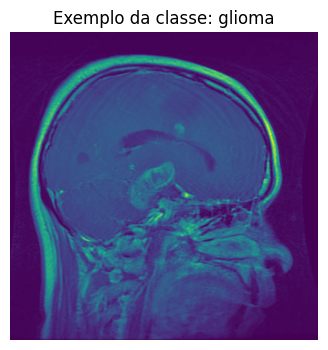

In [58]:
# Visualizando uma imagem aleatória da classe 'glioma'
example_class = "glioma"
example_folder = os.path.join(train_path, example_class)

example_images = glob.glob(os.path.join(example_folder, "*.jpg")) + \
                 glob.glob(os.path.join(example_folder, "*.jpeg")) + \
                 glob.glob(os.path.join(example_folder, "*.png"))

if example_images:
    random_image = random.choice(example_images)
    img = Image.open(random_image)

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Exemplo da classe: {example_class}")
    plt.axis("off")
    plt.show()
else:
    print(f"Nenhuma imagem encontrada na pasta {example_class}")


In [59]:
# Separando 15% das imagens de treinamento para validação
val_ratio = 0.15

if not any(os.listdir(val_path)):
    print("\n🔁 Separando 15% do treino para validação...\n")
    for class_name in os.listdir(train_path):
        train_class = os.path.join(train_path, class_name)
        val_class = os.path.join(val_path, class_name)

        os.makedirs(val_class, exist_ok=True)

        images = os.listdir(train_class)
        random.shuffle(images)

        val_count = int(len(images) * val_ratio)
        val_images = images[:val_count]

        for image in val_images:
            src = os.path.join(train_class, image)
            dst = os.path.join(val_class, image)
            shutil.move(src, dst)

    print("✅ Validação separada com sucesso!\n")
else:
    print("\n⚠️  Validação já foi separada anteriormente. Nenhuma alteração feita.\n")



⚠️  Validação já foi separada anteriormente. Nenhuma alteração feita.



In [60]:
# Exibindo resumo final dos conjuntos de dados
def print_summary(path, name):
    print(f"📂 {name.upper()} SET:")
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            print(f"{class_name}: {num_images} imagens")
    print()

print_summary(train_path, "training")
print_summary(val_path, "validation")
print_summary(test_path, "testing")


📂 TRAINING SET:
glioma: 1123 imagens
meningioma: 1139 imagens
notumor: 1356 imagens
pituitary: 1239 imagens

📂 VALIDATION SET:
glioma: 198 imagens
meningioma: 200 imagens
notumor: 239 imagens
pituitary: 218 imagens

📂 TESTING SET:
glioma: 300 imagens
meningioma: 306 imagens
glioma: 300 imagens
meningioma: 306 imagens
notumor: 405 imagens
pituitary: 300 imagens

notumor: 405 imagens
pituitary: 300 imagens



In [61]:
# Parâmetros principais
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32

# Diretórios dos dados
dataset_path = r"D:\FIAP\Brain Tumor"
train_dir = os.path.join(dataset_path, "Training")
validation_dir = os.path.join(dataset_path, "Validation")
test_dir = os.path.join(dataset_path, "Testing")

# Augmentation apenas no treino
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Validação e teste não devem ser aumentados
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Gerador de treino
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# Gerador de validação
validation_generator = val_test_datagen.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# Gerador de teste
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # importante para avaliar corretamente depois
)

# Labels das classes
class_labels = list(train_generator.class_indices.keys())
print("Classes:", class_labels)

Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Found 1311 images belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
# Transfer Learning com MobileNetV2
base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Treina só o topo

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Exibindo o resumo da arquitetura
model.summary()

# Compilação do modelo
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0003)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

C:\Users\vinic\AppData\Local\Temp\ipykernel_19276\427518313.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [63]:
# Callback para parar o treino automaticamente se a validação parar de melhorar
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Callback para reduzir o learning rate quando parar de melhorar
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [64]:
# Definindo número máximo de épocas
EPOCHS = 25

# Calculando class_weights para balancear as classes
import numpy as np
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Treinando o modelo
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 109s 696ms/step - accuracy: 0.5817 - loss: 0.9979 - val_accuracy: 0.8351 - val_loss: 0.4471 - learning_rate: 3.0000e-04
Epoch 2/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 109s 696ms/step - accuracy: 0.5817 - loss: 0.9979 - val_accuracy: 0.8351 - val_loss: 0.4471 - learning_rate: 3.0000e-04
Epoch 2/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 103s 677ms/step - accuracy: 0.8512 - loss: 0.4412 - val_accuracy: 0.8468 - val_loss: 0.4070 - learning_rate: 3.0000e-04
Epoch 3/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 103s 677ms/step - accuracy: 0.8512 - loss: 0.4412 - val_accuracy: 0.8468 - val_loss: 0.4070 - learning_rate: 3.0000e-04
Epoch 3/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 103s 674ms/step - accuracy: 0.8569 - loss: 0.4022 - val_accuracy: 0.8667 - val_loss: 0.3716 - learning_rate: 3.0000e-04
Epoch 4/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 103s 674ms/step - accuracy: 0.8569 - loss: 0.4022 - val_accuracy: 0.8667 - val_loss: 0.3716 - learning_rate: 3.0000e-04
Epoch 4/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 

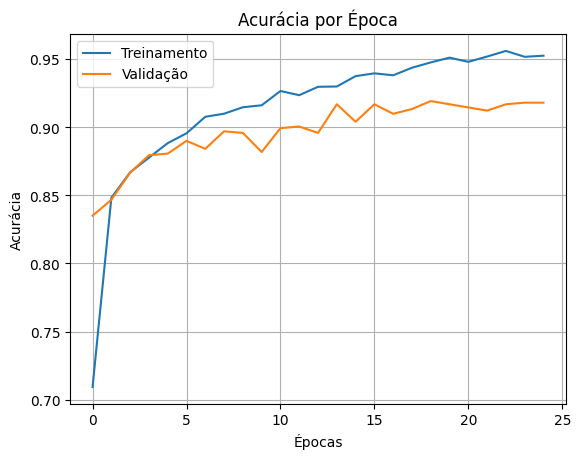

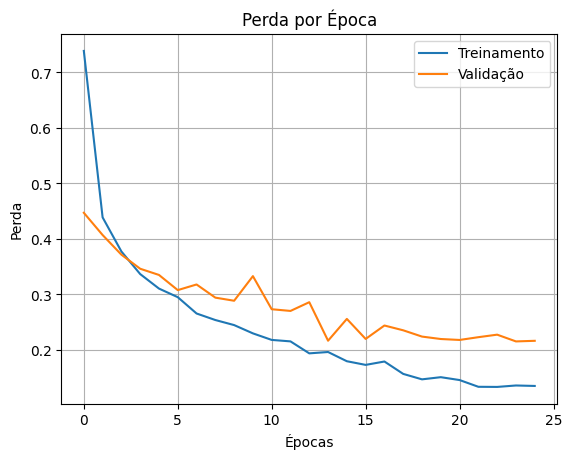

In [65]:
# Acurácia
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia por Época')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

# Perda
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda por Época')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)
plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 462ms/step - accuracy: 0.8734 - loss: 0.3084
41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 462ms/step - accuracy: 0.8734 - loss: 0.3084

✅ Acurácia no Teste: 91.53%
📉 Perda no Teste: 0.2135

✅ Acurácia no Teste: 91.53%
📉 Perda no Teste: 0.2135
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 471ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 471ms/step


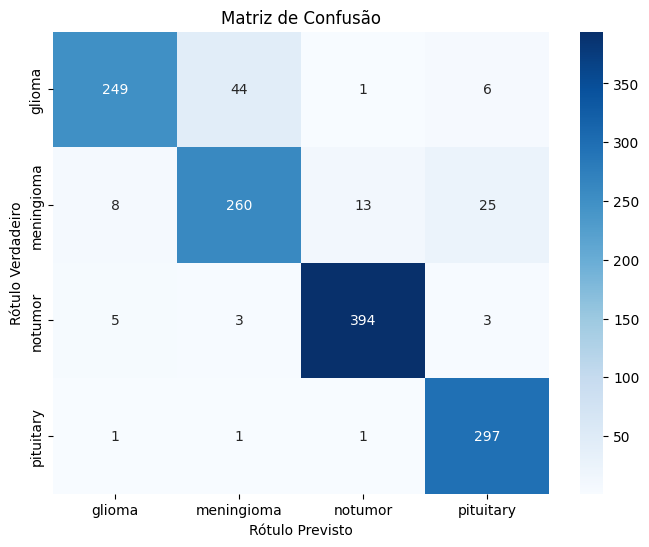


📋 Relatório de Classificação:

              precision    recall  f1-score   support

      glioma       0.95      0.83      0.88       300
  meningioma       0.84      0.85      0.85       306
     notumor       0.96      0.97      0.97       405
   pituitary       0.90      0.99      0.94       300

    accuracy                           0.92      1311
   macro avg       0.91      0.91      0.91      1311
weighted avg       0.92      0.92      0.91      1311



In [66]:
# Avaliação do modelo no conjunto de teste
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\n✅ Acurácia no Teste: {test_accuracy * 100:.2f}%")
print(f"📉 Perda no Teste: {test_loss:.4f}")

# Predições no conjunto de teste
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Rótulos das classes
class_labels = list(test_generator.class_indices.keys())

# Matriz de confusão
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

# Classification Report
print("\n📋 Relatório de Classificação:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


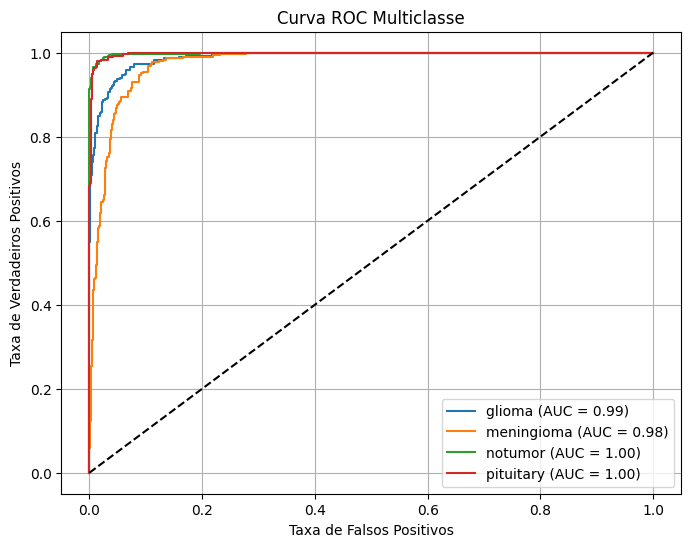

In [67]:
# Curva ROC e AUC para cada classe
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarizando os rótulos verdadeiros (one-hot) para multi-ROC
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_labels)))

# Plot da ROC para cada classe
plt.figure(figsize=(8, 6))

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # linha de referência
plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")
plt.title("Curva ROC Multiclasse")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


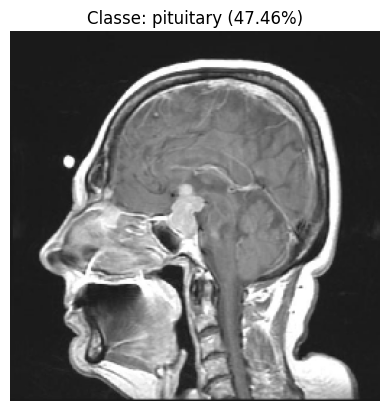


🧠 Resultado: pituitary com 47.46% de confiança


In [71]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

# Caminho completo da imagem nova
img_path = r"D:\FIAP\Brain Tumor\new image\nova_img.jpg"

# Carregar e redimensionar a imagem
img = image.load_img(img_path, target_size=(256, 256))  # igual ao seu modelo
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalização como no treino
img_array = np.expand_dims(img_array, axis=0)  # shape: (1, 256, 256, 3)

# Predição
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
confidence = np.max(prediction)

# Mostrar resultado
plt.imshow(img)
plt.axis('off')
plt.title(f"Classe: {class_labels[predicted_class]} ({confidence*100:.2f}%)")
plt.show()

# Também pode imprimir o texto puro
print(f"\n🧠 Resultado: {class_labels[predicted_class]} com {confidence*100:.2f}% de confiança")



In [73]:
model.save("modelo_brain_tumor.keras")
from tensorflow.keras.models import load_model
model = load_model("modelo_brain_tumor.keras")



In [74]:
import streamlit as st
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

# Carregar modelo treinado
model = load_model("modelo_brain_tumor.keras")
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Interface
st.title("Classificador de Tumores Cerebrais por MRI")

uploaded_file = st.file_uploader("Envie uma imagem de ressonância (MRI)...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    img = Image.open(uploaded_file)
    st.image(img, caption="Imagem Enviada", use_column_width=True)

    # Pré-processamento
    img = img.resize((256, 256))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predição
    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction)

    st.subheader(f"Resultado: {predicted_class} ({confidence*100:.2f}%)")


2025-05-21 08:11:18.712 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-21 08:11:19.000 
  command:

    streamlit run C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-05-21 08:11:19.001 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-21 08:11:19.001 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-21 08:11:19.001 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-21 08:11:19.002 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-21 08:11:19.002 Thread 'MainThread': missing ScriptRunContext! This w